# Python implementation of Logistic Regression from scratch

_Umberto Michelucci, um@udata.science_

### Abstract

In this notebook I develop a complete version of Logistic Regression from scratch, without using any library (except numpy). I apply the model to a subset of MNIST data containing only the digits 1 and 2 (see the data preparation part to see how to do it) to do binary classification. For the equations and the mathematics behind the python code you can refer (to this notebook)[http://localhost:8888/notebooks/Documents/Data%20Science/Projects/Logistic-Regression-Explained/Logistic%20Regression%20from%20scratch.ipynb#] where I did a complete derivation of the mathematics behind the model. The relevant equations are reported here to make it easier for the reader to follow the code.

**NOTE**: the formulas are not explained or derived and are reported only to help the reader follow the Python code. For a derivation and justification please refer to the notebook above.

## Libraries

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

from random import *

## Data preparation

To get MNIST data we use the function fetch_mldata, in the datasets package. Let's get all the dataset, and then we will select only the digits we want.

In [2]:
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [5]:
X,y = mnist["data"], mnist["target"]

In [6]:
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

To know how many digits we have we can run this simple code

In [8]:
total = 0
for i in range(10):
    print ("digit", i, "appear", np.count_nonzero(y == i), "times")

digit 0 appear 6903 times
digit 1 appear 7877 times
digit 2 appear 6990 times
digit 3 appear 7141 times
digit 4 appear 6824 times
digit 5 appear 6313 times
digit 6 appear 6876 times
digit 7 appear 7293 times
digit 8 appear 6825 times
digit 9 appear 6958 times


In [13]:
total = 0
for i in range(10):
    print ("digit", i, "makes", np.around(np.count_nonzero(y == i)/70000.0*100.0, decimals=1), "% of the 70000 observations")

digit 0 makes 9.9 % of the 70000 observations
digit 1 makes 11.3 % of the 70000 observations
digit 2 makes 10.0 % of the 70000 observations
digit 3 makes 10.2 % of the 70000 observations
digit 4 makes 9.7 % of the 70000 observations
digit 5 makes 9.0 % of the 70000 observations
digit 6 makes 9.8 % of the 70000 observations
digit 7 makes 10.4 % of the 70000 observations
digit 8 makes 9.8 % of the 70000 observations
digit 9 makes 9.9 % of the 70000 observations


# Let's check the distribution if we create a dev dataset

In [15]:
np.random.seed(42)
rnd = np.random.rand(len(y)) < 0.8

train_y = y[rnd]
dev_y = y[~rnd]

print(train_y.shape)
print(dev_y.shape)

(56056,)
(13944,)


Note: datasets loaded by scikit-learn have a dictionary structure. 

- a DESCR structure describing the dataset
- a ```data``` key containing an array with one row per instance and one column per feature
- a ```target``` with an array with the labels

we have 70000 digits available, from 0 to 9. Let's define a helper function that will allow us to visualize the digits.

In [17]:
total = 0
for i in range(10):
    print ("digit", i, "makes", np.around(np.count_nonzero(train_y == i)/56056.0*100.0, decimals=1), "% of the 56056 observations")

digit 0 makes 9.9 % of the 56056 observations
digit 1 makes 11.3 % of the 56056 observations
digit 2 makes 9.9 % of the 56056 observations
digit 3 makes 10.1 % of the 56056 observations
digit 4 makes 9.8 % of the 56056 observations
digit 5 makes 9.0 % of the 56056 observations
digit 6 makes 9.8 % of the 56056 observations
digit 7 makes 10.4 % of the 56056 observations
digit 8 makes 9.8 % of the 56056 observations
digit 9 makes 9.9 % of the 56056 observations


# Case for splitting with sorting

In [51]:
True*10

10

In [55]:
srt = np.zeros_like(y,  dtype=bool)

np.random.seed(42)
srt[0:56000] = True

train_y = y[srt]
dev_y = y[~srt]

In [58]:
total = 0
for i in range(10):
    print ("class", i, "makes", np.around(np.count_nonzero(train_y == i)/70000.0*100.0, decimals=1), "% of the 70000 observations")

class 0 makes 8.5 % of the 70000 observations
class 1 makes 9.6 % of the 70000 observations
class 2 makes 8.5 % of the 70000 observations
class 3 makes 8.8 % of the 70000 observations
class 4 makes 8.3 % of the 70000 observations
class 5 makes 7.7 % of the 70000 observations
class 6 makes 8.5 % of the 70000 observations
class 7 makes 9.0 % of the 70000 observations
class 8 makes 8.4 % of the 70000 observations
class 9 makes 2.8 % of the 70000 observations


In [33]:
total = 0
for i in range(2):
    print ("class", i, "makes", np.around(np.count_nonzero(dev_y == i)/13944.0*100.0, decimals=1), "% of the 13944 observations")

class 0 makes 9.7 % of the 13944 observations
class 1 makes 90.3 % of the 13944 observations


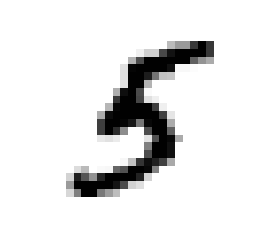

In [7]:
def plot_digit(some_digit):
    
    some_digit_image = some_digit.reshape(28,28)

    plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = "nearest")
    plt.axis("off")
    plt.show()
    
plot_digit(X[36003])

Let's check the relative label...

In [8]:
y[36003]

5.0

### Train and test set preparation

Let's first reduce our dataset only to 1 and 2 digits.

In [9]:
X_train = X[np.any([y == 1,y == 2], axis = 0)]
y_train = y[np.any([y == 1,y == 2], axis = 0)]

The size of our dataset is

In [10]:
print(X_train.shape)
print(y_train.shape)

(14867, 784)
(14867,)


In our reduced dataset how many 1 and 2 do we have?

In [11]:
print("number of 1:", np.count_nonzero(y_train == 1))
print("number of 2:", np.count_nonzero(y_train == 2))

number of 1: 7877
number of 2: 6990


## Normalisation

Let's normalise our data. The pixel will have a value between 0 and 255 (gray values). Let's normalise the value between 0 and 1.

In [12]:
X_train_normalised = X_train/255.0

Remember that we need features along the rows, and training cases along the columns. So let's reshape our dataset

In [13]:
X_train_tr = X_train_normalised.transpose()
y_train_tr = y_train.reshape(1,y_train.shape[0])

print(X_train_tr.shape)
print(y_train_tr.shape)

n_dim = X_train_tr.shape[0]
dim_train = X_train_tr.shape[1]


print(n_dim)
print("The training dataset has", dim_train, "observations (m).")

(784, 14867)
(1, 14867)
784
The training dataset has 14867 observations (m).


We will need to rescale our lables. Remember we will compare them in the cost function with 0 and 1 (proabilities) and therefore our class labels must be 0 and 1, not 1 and 2. So the following step take care of it.

In [14]:
y_train_shifted = y_train_tr - 1

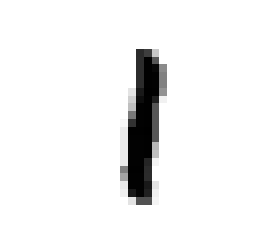

[ 0.]


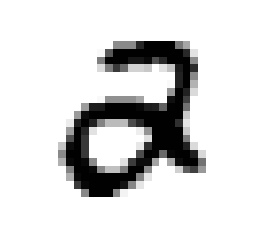

[ 1.]


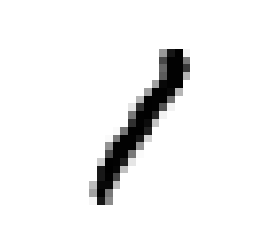

[ 0.]


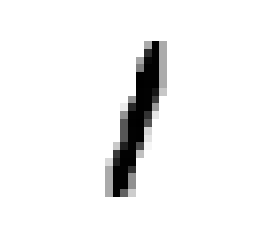

[ 0.]


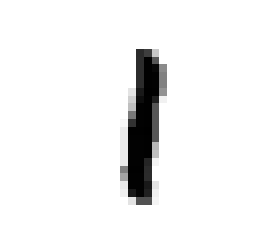

In [19]:
plot_digit(X_train_tr[:,1005])
print(y_train_shifted[:,1005])
plot_digit(X_train_tr[:,8000])
print(y_train_shifted[:,8000])
plot_digit(X_train_tr[:,456])
print(y_train_shifted[:,456])
plot_digit(X_train_tr[:,567])
print(y_train_shifted[:,567])

Xtrain = X_train_tr
ytrain = y_train_shifted

plot_digit(Xtrain[:,1005])

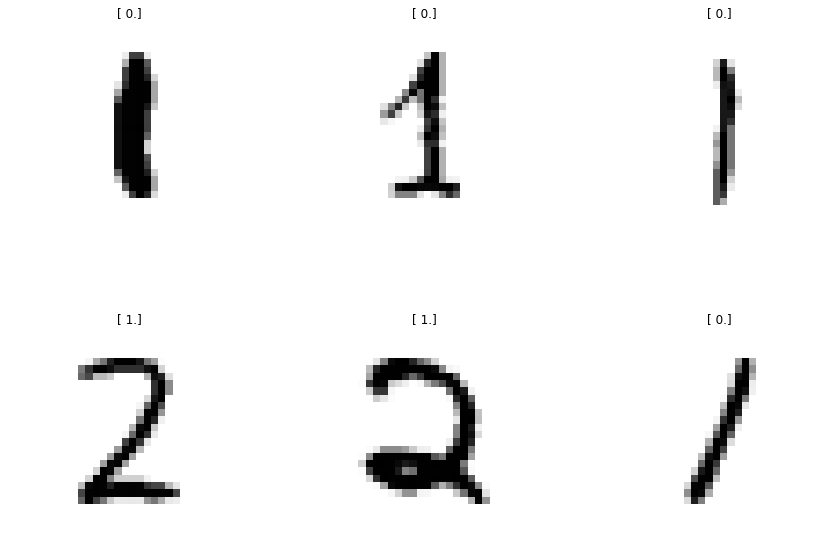

In [26]:
f = plt.figure(figsize=(15,15));
count = 1
for i in [randint(1, 14867),randint(1, 14867),randint(1, 14867),randint(1, 14867),randint(1, 14867),randint(1, 14867)]:
    plt.subplot(3,3,count)
    count = count + 1
    plt.subplots_adjust(hspace=0.5)
    plt.title(ytrain[:,i])
    some_digit_image = Xtrain[:,i].reshape(28,28)
    plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = "nearest")
    plt.axis("off")
    pass

# Tensorflow Implementation

In [28]:
import tensorflow as tf

In [29]:
print(Xtrain.shape)
print(ytrain.shape)

(784, 14867)
(1, 14867)


In [30]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [n_dim, None])
Y = tf.placeholder(tf.float32, [1, None])
learning_rate = tf.placeholder(tf.float32, shape=())

#W = tf.Variable(tf.random_normal([1, n_dim]))/10.0
W = tf.Variable(tf.zeros([1, n_dim]))
#b = tf.Variable(tf.random_normal([1]))/10.0
b = tf.Variable(tf.zeros(1))

init = tf.global_variables_initializer()

In [31]:
y_ = tf.sigmoid(tf.matmul(W,X)+b)
cost = - tf.reduce_mean(Y * tf.log(y_)+(1-Y) * tf.log(1-y_))
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [32]:
def run_logistic_model(learning_r, training_epochs, train_obs, train_labels, debug = False):
    sess = tf.Session()
    sess.run(init)
    
    cost_history = np.empty(shape=[0], dtype = float)

    for epoch in range(training_epochs+1):
        
        sess.run(training_step, feed_dict = {X: train_obs, Y: train_labels, learning_rate: learning_r})

        cost_ = sess.run(cost, feed_dict={ X:train_obs, Y: train_labels, learning_rate: learning_r})
        cost_history = np.append(cost_history, cost_)
        
        if (epoch % 500 == 0) & debug:
            print("Reached epoch",epoch,"cost J =", str.format('{0:.6f}', cost_))
            
    return sess, cost_history

In [33]:
sess = tf.Session()
sess.run(init)
print(sess.run(y_, feed_dict={X:Xtrain, Y: ytrain, learning_rate: 2}))
print(sess.run(cost, feed_dict={X:Xtrain, Y: ytrain, learning_rate: 2}))
sess.close()

[[ 0.5  0.5  0.5 ...,  0.5  0.5  0.5]]
0.693133


In [ ]:
sess, cost_history = run_logistic_model(learning_r = 0.01, 
                                training_epochs = 5000, 
                                train_obs = Xtrain, 
                                train_labels = ytrain, 
                                debug = True)

In [34]:
sess, cost_history = run_logistic_model(learning_r = 0.005, 
                                training_epochs = 5000, 
                                train_obs = Xtrain, 
                                train_labels = ytrain, 
                                debug = True) 

Reached epoch 0 cost J = 0.685799
Reached epoch 500 cost J = 0.154386
Reached epoch 1000 cost J = 0.108590
Reached epoch 1500 cost J = 0.089566
Reached epoch 2000 cost J = 0.078767
Reached epoch 2500 cost J = 0.071669
Reached epoch 3000 cost J = 0.066580
Reached epoch 3500 cost J = 0.062715
Reached epoch 4000 cost J = 0.059656
Reached epoch 4500 cost J = 0.057158
Reached epoch 5000 cost J = 0.055069


# Figure 1-19

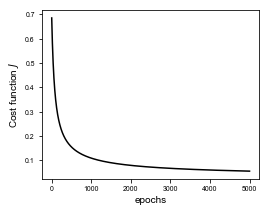

In [35]:
plt.rc('font', family='arial')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
    
plt.tight_layout()

fig = plt.figure(figsize=(3.9, 3.1))
ax = fig.add_subplot(1, 1, 1)
ax.plot(cost_history, ls='solid', color = 'black')
ax.set_xlabel('epochs')
ax.set_ylabel('Cost function $J$')

fig.savefig('Figure_1-19'+'.pdf', format='pdf', dpi=300,bbox_inches='tight')
fig.savefig('Figure_1-19'+'.png', format='png', dpi=300,bbox_inches='tight')

In [ ]:
sess, cost_history = run_logistic_model(learning_r = 0.05, 
                                training_epochs = 7000, 
                                train_obs = Xtrain, 
                                train_labels = ytrain, 
                                debug = True)

In [ ]:
correct_prediction1=tf.equal(tf.greater(y_, 0.5), tf.equal(Y,1))

accuracy1 = tf.reduce_mean(tf.cast(correct_prediction1, tf.float32))

print(sess.run(accuracy1, feed_dict={X:Xtrain, Y: ytrain, learning_rate: 0.05}))

In [ ]:
plt.rc('font', family='arial')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
    
plt.tight_layout()

fig = plt.figure(figsize=(3.9, 3.1))
ax = fig.add_subplot(1, 1, 1)
   #x = np.linspace(1., 8., 30)
ax.plot(cost_history, ls='solid', color = 'black')
#ax.plot(J2, ls='dashed', color = 'black', label='$\gamma=2.0$')
#ax.plot(J3, ls='dotted', color = 'black', label='$\gamma=0.05$')
ax.set_xlabel('epochs')
ax.set_ylabel('Cost function $J$')
#plt.xlim(0,8)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#fig.savefig('Figure_1-14'+'.pdf', format='pdf', dpi=300,bbox_inches='tight')
#fig.savefig('Figure_1-14'+'.png', format='png', dpi=300,bbox_inches='tight')

In [ ]:
print(sess.run(y_, feed_dict={X:Xtrain, Y: ytrain, learning_rate: 0.05}))
print(sess.run(tf.greater(y_, 0.5), feed_dict={X:Xtrain, Y: ytrain, learning_rate: 0.05}))
print(sess.run(tf.less(y_, 0.5), feed_dict={X:Xtrain, Y: ytrain, learning_rate: 0.05}))
print(sess.run(tf.cast(tf.less(y_, 0.5), tf.float32), feed_dict={X:Xtrain, Y: ytrain, learning_rate: 0.05}))
print(sess.run(tf.reduce_mean(tf.cast(tf.less(y_, 0.5), tf.float32)), feed_dict={X:Xtrain, Y: ytrain, learning_rate: 0.05}))
print(sess.run(tf.reduce_mean(tf.cast(tf.greater(y_, 0.5), tf.float32)), feed_dict={X:Xtrain, Y: ytrain, learning_rate: 0.05}))


print(sess.run(tf.equal(Y,1), feed_dict={X:Xtrain, Y: ytrain, learning_rate: 0.05}))

print(sess.run(tf.equal(Y,1), feed_dict={X:Xtrain, Y: ytrain, learning_rate: 0.05}))


#tf.matmul(W,X)+b

print(sess.run(W, feed_dict={X:Xtrain, Y: ytrain, learning_rate: 0.005}))

## Logistic model with a check for the bias $b$

In [30]:
def run_logistic_model_b(learning_r, training_epochs, train_obs, train_labels, debug = False):
    sess = tf.Session()
    sess.run(init)
    
    cost_history = np.empty(shape=[0], dtype = float)

    for epoch in range(training_epochs+1):
        print ('epoch: ', epoch)
        print(sess.run(b, feed_dict={X:train_obs, Y: train_labels, learning_rate: learning_r}))
        
        sess.run(training_step, feed_dict = {X: train_obs, Y: train_labels, learning_rate: learning_r})
        print(sess.run(b, feed_dict={X:train_obs, Y: train_labels, learning_rate: learning_r}))
        

        cost_ = sess.run(cost, feed_dict={ X:train_obs, Y: train_labels, learning_rate: learning_r})
        cost_history = np.append(cost_history, cost_)
        
        if (epoch % 500 == 0) & debug:
            print("Reached epoch",epoch,"cost J =", str.format('{0:.6f}', cost_))
            
    return sess, cost_history

In [33]:
sess, cost_history = run_logistic_model_b(learning_r = 2.0, 
                                training_epochs = 1, 
                                train_obs = Xtrain, 
                                train_labels = ytrain, 
                                debug = True)

epoch:  0
[ 0.]
[-0.05966223]
Reached epoch 0 cost J = nan
epoch:  1
[-0.05966223]
[ nan]


## Logistic Regression with sklearn

As a side note, here is the code to see how easy it is in comparison to do the same with the sklearn library... 

In [ ]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()

In [ ]:
XX = Xtrain.T
YY = ytrain.T.ravel()

logistic.fit(XX,YY)

In [ ]:
logistic.score(XX,YY)

The score is calculated as 

In [ ]:
sum(logistic.predict(XX) == YY) / len(XX)